<a href="https://colab.research.google.com/github/GabrielSMedina/TCC/blob/main/TCC_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## O que será executado:

In [ ]:
executar_validacoes = False
executar_criacao_ceps = False
executar_criacao_dataset = False

## Importações

In [ ]:
import os
import pandas as pd
import requests
import random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import csv
from scipy.stats import kurtosis

## Validando dados xlsx

Estas validações são referentes aos dados XLSX fornecidos pelo site oficial da prefeitura de São Paulo

#### Anos presentes nos arquivos

In [ ]:
def verificar_anos_existentes(diretorio, anos_esperados):
  anos_existentes = [int(nome.split('.')[0]) for nome in os.listdir(diretorio) if nome.endswith('.xlsx')]
  anos_faltantes = [ano for ano in anos_esperados if ano not in anos_existentes]
  print('Verificando anos existentes: ')

  if anos_faltantes:
    print(f"Anos faltantes: {anos_faltantes}")
  else:
    print("Todos os anos estão presentes.")

#### Verificação dos meses presentes em cada ano

In [ ]:
def verificar_sheets_por_mes(diretorio, anos):
  meses = ['JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ']
  count = 0
  print('-'*30)
  print('Verificando sheets de meses: ')
  for ano in anos:
    arquivo = f"{ano}.xlsx"
    caminho_arquivo = os.path.join(diretorio, arquivo)
    if os.path.exists(caminho_arquivo):
      xls = pd.ExcelFile(caminho_arquivo)
      sheets_faltantes = [f"{mes}-{ano}" for mes in meses if f"{mes}-{ano}" not in xls.sheet_names]
      if sheets_faltantes:
        print(f"Sheets faltantes no ano {ano}, arquivo {arquivo}: {sheets_faltantes}")
        count += 1

  if count == 0:
    print('Todos os meses estão presentes')

#### Verificando se o padrão de nomenclatura das colunas permanece em todos os arquivos

In [ ]:
def verificar_nomes_colunas(diretorio, anos):
  primeiro_ano = anos[0]
  primeiro_arquivo = f"{primeiro_ano}.xlsx"
  caminho_primeiro_arquivo = os.path.join(diretorio, primeiro_arquivo)

  print('-'*30)
  print('Verificação de colunas:')
  count = 0

  if os.path.exists(caminho_primeiro_arquivo):
    xls = pd.ExcelFile(caminho_primeiro_arquivo)
    df_primeiro_arquivo = pd.read_excel(caminho_primeiro_arquivo, sheet_name=xls.sheet_names[0])
    colunas_padrao = df_primeiro_arquivo.columns.tolist()
  else:
    print(f"Arquivo {primeiro_arquivo} não encontrado.")
    return

  for ano in anos:
    print(f"Verificando ano {ano}")
    arquivo = f"{ano}.xlsx"
    caminho_arquivo = os.path.join(diretorio, arquivo)
    if os.path.exists(caminho_arquivo):
      xls = pd.ExcelFile(caminho_arquivo)
      for sheet in xls.sheet_names:
        df = pd.read_excel(caminho_arquivo, sheet_name=sheet)
        colunas_diferentes = [col for col in df.columns if col not in colunas_padrao]
        if colunas_diferentes:
          print(f"Colunas diferentes no ano {ano}, arquivo {arquivo}, sheet {sheet}: {colunas_diferentes}")
          count += 1

  if count == 0:
    print('Todas as colunas estão corretas')
  else:
    print(f'Total de arquivos com colunas diferentes: {count}')

### Chamada das validações

In [ ]:
diretorio = '/content/drive/MyDrive/dados_tcc/xlsx_tratados'
anos_esperados = list(range(2006, 2024))

if executar_validacoes :
  verificar_anos_existentes(diretorio, anos_esperados)
  verificar_sheets_por_mes(diretorio, anos_esperados)
  verificar_nomes_colunas(diretorio, anos_esperados)

## Criando dataset de CEPs

#### Extraindo CEPs dos arquivos originais em XLSX

In [ ]:
def extrair_coluna_cep(diretorio):
    coluna_extrair = 'CEP'

    df_ceps = pd.DataFrame(columns=[coluna_extrair])

    if not os.path.exists(diretorio):
        print(f"O diretório '{diretorio}' não existe.")
        return pd.DataFrame()

    for arquivo in os.listdir(diretorio):
        if arquivo.endswith('.xlsx'):
            caminho_arquivo = os.path.join(diretorio, arquivo)
            print(f"Processando arquivo: {arquivo}")

            try:
                xls = pd.ExcelFile(caminho_arquivo)

                for sheet in xls.sheet_names:
                    print(f"  Lendo planilha: {sheet}")
                    _df = pd.read_excel(caminho_arquivo, sheet_name=sheet)

                    if coluna_extrair in _df.columns:
                        print(f"    Coluna '{coluna_extrair}' encontrada na planilha '{sheet}'.")
                        ceps = _df[[coluna_extrair]].dropna()
                        df_ceps = pd.concat([df_ceps, ceps], ignore_index=True)
                    else:
                        print(f"    Coluna '{coluna_extrair}' NÃO encontrada na planilha '{sheet}'.")
            except Exception as e:
                print(f"Erro ao processar o arquivo {arquivo}: {e}")

    if not df_ceps.empty:
        print(f"Total de CEPs extraídos: {len(df_ceps)}")
        return df_ceps
    else:
        print("Nenhum dado foi encontrado para ser salvo.")
        return pd.DataFrame()

#### Criando dataset para relacionar CEPs e adicionar dados de geolocalização

In [ ]:
def criar_relacao(_df_ceps, _df_sp_data):

  if 'CEP' not in _df_sp_data.columns:
      print("A coluna 'CEP' não foi encontrada no arquivo sp_data.xlsx.")
  else:
      _df_ceps['CEP'] = _df_ceps['CEP'].astype(float).astype(int)

      _df_sp_data['CEP'] = _df_sp_data['CEP'].astype(int)

      ceps_unicos = _df_ceps['CEP'].unique()
      total_ceps_unicos = len(ceps_unicos)
      print(f"Total de CEPs únicos no df_ceps: {total_ceps_unicos}")

      ceps_existentes = _df_sp_data['CEP'].unique()
      ceps_em_comum = set(ceps_unicos).intersection(set(ceps_existentes))
      total_ceps_em_comum = len(ceps_em_comum)
      print(f"Total de CEPs únicos que existem em sp_data.xlsx: {total_ceps_em_comum}")

      ceps_faltantes = set(ceps_unicos).difference(set(ceps_existentes))
      total_ceps_faltantes = len(ceps_faltantes)
      print(f"Total de CEPs únicos que NÃO existem em sp_data.xlsx: {total_ceps_faltantes}")

      if total_ceps_faltantes > 0:
          pd.DataFrame(list(ceps_faltantes), columns=['CEP']).to_csv('ceps_faltantes.csv', index=False)
          print("Arquivo 'ceps_faltantes.csv' criado com os CEPs que não estão em sp_data.xlsx.")


      if 'CEP' not in _df_sp_data.columns:
          print("A coluna 'CEP' não foi encontrada no arquivo sp_data.xlsx.")
      else:
          _df_ceps['CEP'] = _df_ceps['CEP'].astype(float).astype(int)
          _df_sp_data['CEP'] = _df_sp_data['CEP'].astype(int)

          _df_ceps_atualizado = pd.merge(
              _df_ceps,
              _df_sp_data[['CEP', 'Endereço', 'Bairro', 'Longitude', 'Latitude']],
              on='CEP',
              how='left'
          )

          _df_ceps_atualizado.to_csv('/content/drive/MyDrive/dados_tcc/dados_cep/ceps_bairros.csv', index=False)
          print("Arquivo 'ceps_bairros.csv' criado com as novas colunas.")

### Chamada da criação do dataset de CEPs

In [ ]:
if executar_criacao_ceps:
  caminho_pasta = '/content/drive/MyDrive/dados_tcc/xlsx_tratados'
  df_cep = extrair_coluna_cep(caminho_pasta)

  caminho_cep_extraido = '/content/drive/MyDrive/dados_tcc/dados_cep/ceps_extraidos_xlsx.csv'
  df_cep.to_csv(caminho_cep_extraido , index=False)

  df_ceps = pd.read_csv(caminho_cep_extraido)
  df_sp_data = pd.read_excel('/content/drive/MyDrive/dados_tcc/dados_cep/sp_data.xlsx')
  criar_relacao(df_ceps, df_sp_data)

## Criando do dataset

#### Mapeando colunas

In [ ]:
mapeamento_colunas = {
    'N° do Cadastro (SQL)': 'n_cadastro',
    'Nome do Logradouro': 'nome_logradouro',
    'Número': 'numero',
    'Complemento': 'complemento',
    'Bairro': 'bairro',
    'Referência': 'referencia',
    'CEP': 'cep',
    'Natureza de Transação': 'natureza_transacao',
    'Valor de Transação (declarado pelo contribuinte)': 'valor_transacao',
    'Data de Transação': 'data_transacao',
    'Valor Venal de Referência': 'valor_venal_referencia',
    'Proporção Transmitida (%)': 'proporcao_transmitida',
    'Valor Venal de Referência (proporcional)': 'valor_venal_referencia_proporcional',
    'Base de Cálculo adotada': 'base_calculo',
    'Tipo de Financiamento': 'tipo_financiamento',
    'Valor Financiado': 'valor_financiado',
    'Cartório de Registro': 'cartorio_de_registro',
    'Matrícula do Imóvel': 'matricula_imovel',
    'Situação do SQL': 'situacao_no_sql',
    'Área do Terreno (m2)': 'area_terreno',
    'Testada (m)': 'testada',
    'Fração Ideal': 'fracao_ideal',
    'Área Construída (m2)': 'area_construida',
    'Uso (IPTU)': 'uso_iptu',
    'Descrição do uso (IPTU)': 'descricao_uso_iptu',
    'Padrão (IPTU)': 'padrao_iptu',
    'Descrição do padrão (IPTU)': 'descricao_padrao_iptu',
    'ACC (IPTU)': 'acc_iptu'
}

colunas_esperadas = list(mapeamento_colunas.values())

#### Extraindo dados dos arquivos XLSX

In [ ]:
def processar_xlsx(diretorio):
    df_total = pd.DataFrame(columns=colunas_esperadas + ['ANO', 'MES_ANO'])
    for arquivo in os.listdir(diretorio):
        if arquivo.endswith('.xlsx'):
            ano = int(arquivo.split('.')[0])
            caminho_arquivo = os.path.join(diretorio, arquivo)
            xls = pd.ExcelFile(caminho_arquivo)

            for sheet in xls.sheet_names:
                _df = pd.read_excel(caminho_arquivo, sheet_name=sheet)

                if not _df.empty:
                    _df = _df.rename(columns=mapeamento_colunas)

                    colunas_faltantes = set(colunas_esperadas) - set(_df.columns)
                    if colunas_faltantes:
                        print(f"Atenção: Colunas faltantes no arquivo {arquivo} (planilha {sheet}): {colunas_faltantes}")
                        for col in colunas_faltantes:
                            _df[col] = pd.NA

                    _df = _df[colunas_esperadas]

                    _df['cep'] = pd.to_numeric(_df['cep'], errors='coerce').astype('Int64')

                    colunas_numericas = [
                        'valor_transacao', 'valor_venal_referencia', 'proporcao_transmitida',
                        'valor_venal_referencia_proporcional', 'base_calculo', 'valor_financiado',
                        'area_terreno', 'testada', 'fracao_ideal', 'area_construida'
                    ]
                    for col in colunas_numericas:
                        _df[col] = pd.to_numeric(_df[col], errors='coerce').astype('Float64')

                    _df['data_transacao'] = pd.to_datetime(_df['data_transacao'], format='%d/%m/%Y', errors='coerce')

                    _df['ANO'] = ano
                    _df['MES_ANO'] = f"{ano}-{sheet.split('-')[0]}"

                    df_total = pd.concat([df_total, _df], ignore_index=True)

    return df_total

#### Tratando arquivo de CEPs

In [ ]:
def remover_duplicatas_ceps(diretorio_ceps):
    _df_cep = pd.read_csv(diretorio_ceps)

    _df_cep_unico = _df_cep.drop_duplicates(subset=['CEP'], keep='first')

    return _df_cep_unico

#### Merge de informações de geolocalização

In [ ]:
def merge_geolocalizacao(_df_cep_unico, _df):

  _df['cep'] = _df['cep'].astype(str).str.strip()
  _df_cep_unico['CEP'] = _df_cep_unico['CEP'].astype(str).str.strip()

  df_cep_tratado = pd.merge(
      _df,
      _df_cep_unico[['CEP', 'Endereço', 'Bairro', 'Longitude', 'Latitude']],
      left_on='cep',
      right_on='CEP',
      how='left'
  )

  if 'CEP' in df_cep_tratado.columns:
      df_cep_tratado.drop(columns=['CEP'], inplace=True)
  return df_cep_tratado

#### Tratando colunas

In [ ]:
def tratamentos(_df):
  if _df.duplicated().any():
      print("Atenção: O DataFrame final contém linhas duplicadas.")
      _df = _df.drop_duplicates()

  _df['n_cadastro'] = _df['n_cadastro'].astype(str)

  _df = _df[
      _df['descricao_padrao_iptu'].str.contains('RESIDENCIAL VERTICAL|RESIDENCIAL HORIZONTAL', case=False, na=False)
  ]

  _df = _df.drop(columns=['numero', 'nome_logradouro', 'complemento', 'referencia'], errors='ignore')

  colunas_texto = ['bairro', 'descricao_padrao_iptu', 'uso_iptu', 'cartorio_de_registro']
  _df[colunas_texto] = _df[colunas_texto].astype(str)

  _df['valor_venal_referencia_proporcional'] = np.where(
      (_df['proporcao_transmitida'] > 0) & (_df['proporcao_transmitida'] <= 1),
      _df['valor_venal_referencia'],
      _df['valor_venal_referencia'] * (_df['proporcao_transmitida'] / 100)
  )

  _df['base_calculo'] = _df[['valor_transacao', 'valor_venal_referencia_proporcional']].max(axis=1)

  _df = _df.drop(columns=['valor_venal_referencia_proporcional', 'valor_venal_referencia', 'proporcao_transmitida', 'valor_transacao'], errors='ignore')

  _df = _df.drop(columns=['bairro'], errors='ignore')
  _df = _df.dropna(subset=['Bairro'])

  return _df


#### Criação das colunas calculadas

In [ ]:
def colunas_calculadas(_df):
  _df['preco_m2_construido'] = _df['base_calculo'] / _df['area_construida']
  _df['preco_m2_terreno'] = _df['base_calculo'] / _df['area_terreno']

  return _df

#### Corrigindo valor segundo a inflação

In [ ]:
def corrigir_inflacao(_df):
  inflacao_anual = {
      2006: 3.14, 2007: 4.46, 2008: 5.90, 2009: 4.31, 2010: 5.91, 2011: 6.50, 2012: 5.84, 2013: 5.91,
      2014: 6.41, 2015: 10.67, 2016: 6.29, 2017: 2.95, 2018: 3.75, 2019: 4.31, 2020: 4.52, 2021: 10.06,
      2022: 5.79, 2023: 4.62, 2024: 4.83,
  }

  fatores_anual = {ano: 1 + (taxa / 100) for ano, taxa in inflacao_anual.items()}

  fatores_correcao = {}
  anos = sorted(fatores_anual.keys(), reverse=True)
  acumulado = 1.0
  for ano in anos:
      fatores_correcao[ano] = acumulado
      acumulado *= fatores_anual[ano]

  _df['Fator_Correcao'] = _df['ANO'].map(fatores_correcao)

  _df['base_calculo_corrigida_2024'] = (_df['base_calculo'] * _df['Fator_Correcao']).round(2)

  lower_bound = df['base_calculo_corrigida_2024'].quantile(0.05)
  upper_bound = df['base_calculo_corrigida_2024'].quantile(0.95)

  _df = _df[_df['base_calculo_corrigida_2024'].between(lower_bound, upper_bound, inclusive="neither")]

  _df.drop(columns=['Fator_Correcao'], inplace=True)

  _df['preco_m2_construido_corrigido_2024'] = _df['base_calculo_corrigida_2024'] / _df['area_construida']

  return _df

#### Remover margem de erro de 10% para mais e para menos

In [ ]:
def remove_outliers(df, column='base_calculo_corrigida_2024', percentil=0.1):
    if column not in df.columns:
        raise ValueError(f"A coluna '{column}' não existe no DataFrame.")

    limite_inferior = df[column].quantile(percentil)
    limite_superior = df[column].quantile(1 - percentil)

    df_filtrado = df[(df[column] >= limite_inferior) & (df[column] <= limite_superior)]

    return df_filtrado

#### Criando dataset em parquet

In [ ]:
def criar_parquet(_df):
  _df.to_parquet('/content/drive/MyDrive/dados_tcc/datasets/ds_tratado.parquet', index=False)
  print("Dataset atualizado salvo com sucesso!")

### Executando criação do dataset

In [ ]:
if executar_criacao_dataset:
  diretorio_xlsx = '/content/drive/MyDrive/dados_tcc/xlsx_tratados'
  diretorio_ceps ='/content/drive/MyDrive/dados_tcc/dados_cep/ceps_bairros.csv'

  df = processar_xlsx(diretorio_xlsx)
  df_cep_unico = remover_duplicatas_ceps(diretorio_ceps)
  df = merge_geolocalizacao(df_cep_unico, df)
  df = tratamentos(df)
  df = colunas_calculadas(df)
  df = corrigir_inflacao(df)
  df = remove_outliers(df)
  criar_parquet(df)

<ipython-input-72-fbff4fef3f5c>:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_total = pd.concat([df_total, _df], ignore_index=True)


Atenção: O DataFrame final contém linhas duplicadas.


<ipython-input-75-912ba0861fa0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['n_cadastro'] = _df['n_cadastro'].astype(str)
<ipython-input-77-b2587ec3c104>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.drop(columns=['Fator_Correcao'], inplace=True)
<ipython-input-77-b2587ec3c104>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

Dataset atualizado salvo com sucesso!


## Exploração do dataset

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/dados_tcc/datasets/ds_tratado.parquet')

#### Informações gerais do dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318145 entries, 0 to 1318144
Data columns (total 29 columns):
 #   Column                              Non-Null Count    Dtype         
---  ------                              --------------    -----         
 0   n_cadastro                          1318145 non-null  object        
 1   cep                                 1318145 non-null  object        
 2   natureza_transacao                  1318145 non-null  object        
 3   data_transacao                      1318145 non-null  datetime64[ns]
 4   base_calculo                        1318145 non-null  Float64       
 5   tipo_financiamento                  318152 non-null   object        
 6   valor_financiado                    1318145 non-null  Float64       
 7   cartorio_de_registro                1318145 non-null  object        
 8   matricula_imovel                    1318145 non-null  float64       
 9   situacao_no_sql                     1318145 non-null  object        

In [ ]:
df.describe()

,data_transacao,base_calculo,valor_financiado,matricula_imovel,area_terreno,testada,fracao_ideal,area_construida,padrao_iptu,acc_iptu,ANO,preco_m2_construido,preco_m2_terreno,base_calculo_corrigida_2024,preco_m2_construido_corrigido_2024
count,1318145,1318145.0,1318145.0,1.318145e+06,1318145.0,1318145.0,1318145.0,1318145.0,1.318145e+06,1.318145e+06,1.318145e+06,1318145.0,1318145.0,1318145.0,1318145.0
mean,2015-06-28 08:36:49.861889280,290868.826146,66425.704823,1.364607e+05,5606.077999,48.954349,0.27709,124.922273,1.898170e+01,1.992382e+03,2.015000e+03,2735.170543,641.979975,444503.861526,4111.763904
min,1994-11-17 00:00:00,47674.6,-560000.0,-1.928030e+05,15.0,0.0,0.0001,1.0,1.000000e+01,1.910000e+03,2.006000e+03,3.387382,0.206274,129435.99,3.387382
25%,2010-04-23 00:00:00,144000.0,0.0,6.110300e+04,315.0,8.0,0.005,80.0,1.200000e+01,1.980000e+03,2.010000e+03,1333.333333,52.438795,265000.0,2713.964046
50%,2014-12-23 00:00:00,250000.0,0.0,1.223190e+05,1452.0,24.0,0.0143,106.0,2.200000e+01,1.994000e+03,2.015000e+03,2424.277444,175.391304,388860.16,3770.573457
75%,2021-01-15 00:00:00,387155.0,104000.0,1.841350e+05,4402.0,56.5,1.0,142.0,2.200000e+01,2.007000e+03,2.021000e+03,3673.469388,672.619048,584203.05,5121.260519
max,2025-01-03 00:00:00,1067553.0,121792000.0,9.999999e+06,233403.0,1427.0,1.0,67720.0,2.500000e+01,2.888000e+03,2.024000e+03,196800.0,30416.197333,1067843.4,384406.365
std,NaN,187779.856859,158836.061851,1.586639e+05,17112.796008,83.005127,0.433978,266.562247,4.802829e+00,1.720017e+01,5.774946e+00,1834.591838,1125.05766,228590.459718,2168.382971


#### Matriz de correlação linear

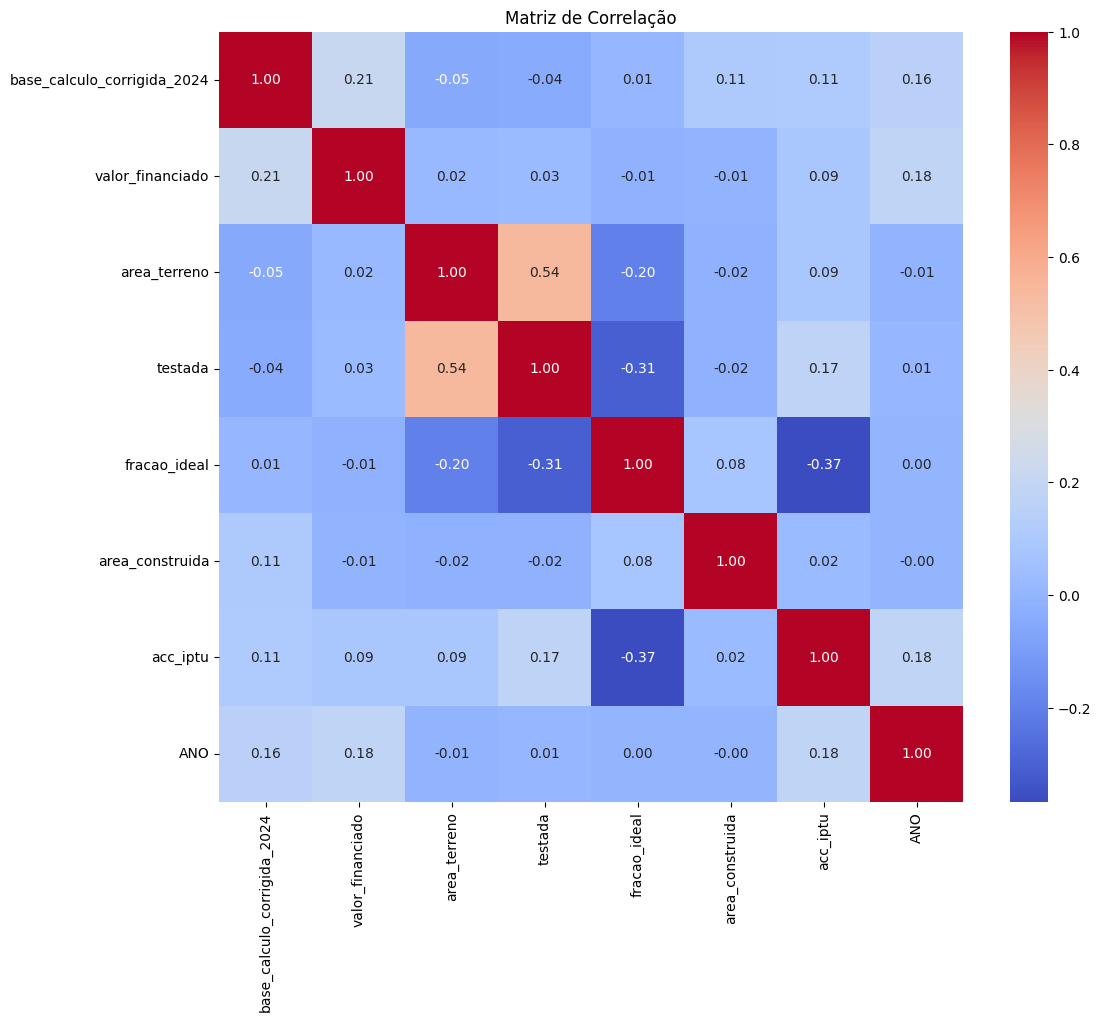

In [ ]:
columns_for_correlation = ['base_calculo_corrigida_2024', 'valor_financiado',
                           'area_terreno', 'testada', 'fracao_ideal', 'area_construida',
                           'acc_iptu', 'ANO']

numeric_columns = df[columns_for_correlation].select_dtypes(include=['number']).columns
correlation_matrix = df[numeric_columns].corr()


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

#### Matriz de correlação de Spearman

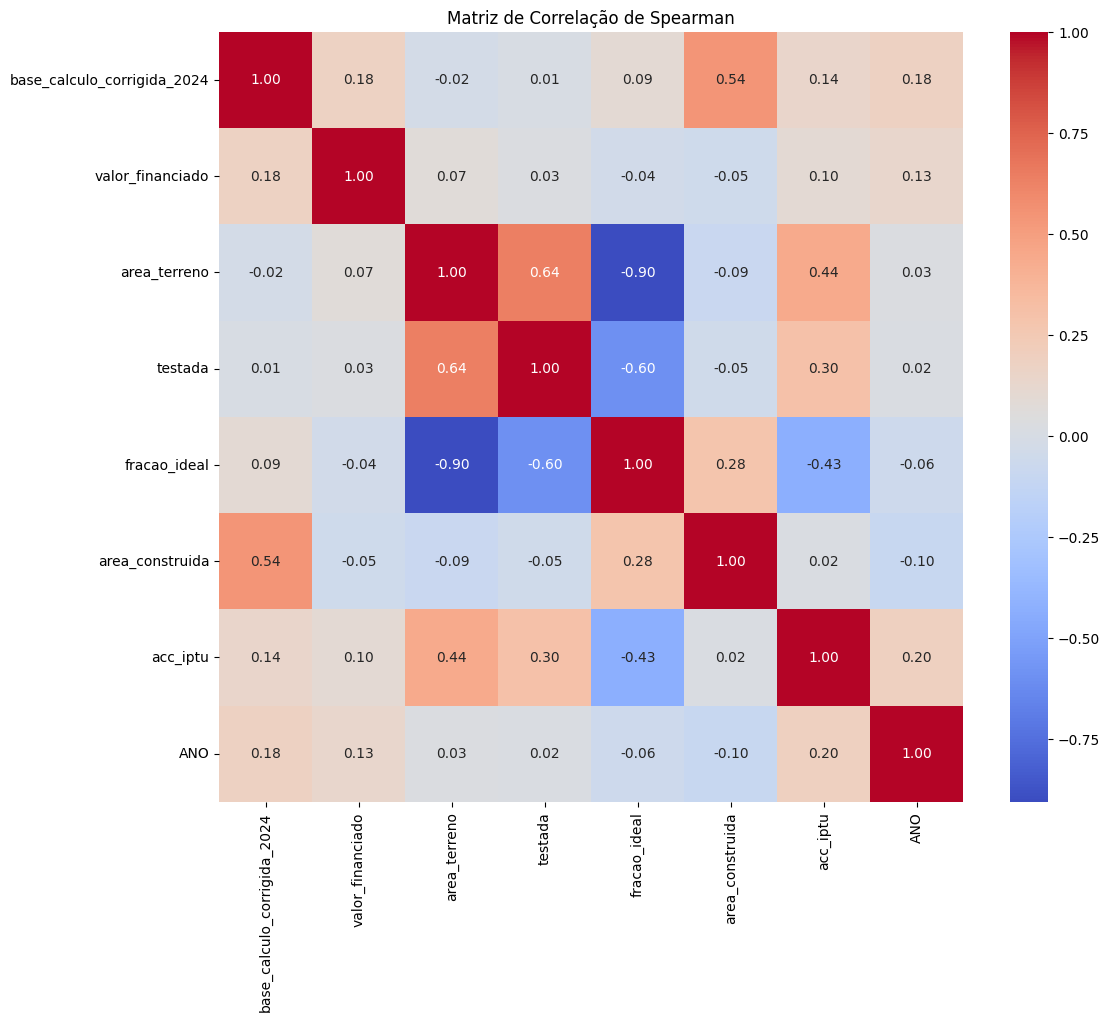

In [ ]:
numeric_columns = ['base_calculo_corrigida_2024', 'valor_financiado',
                           'area_terreno', 'testada', 'fracao_ideal', 'area_construida',
                           'acc_iptu', 'ANO']

df['acc_iptu'] = pd.to_numeric(df['acc_iptu'], errors='coerce')

df['acc_iptu'] = df['acc_iptu'].replace('RESIDENCIAL VERTICAL', pd.NA)

df = df.dropna(subset=['acc_iptu'])


correlation_matrix_spearman = df[numeric_columns].corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação de Spearman')
plt.show()

#### Base de calculo corrigida pela inflação

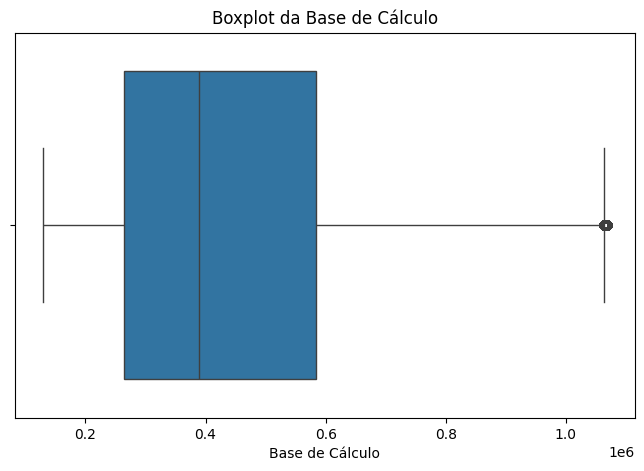

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['base_calculo_corrigida_2024'])
plt.title('Boxplot da Base de Cálculo')
plt.xlabel('Base de Cálculo')
plt.show()

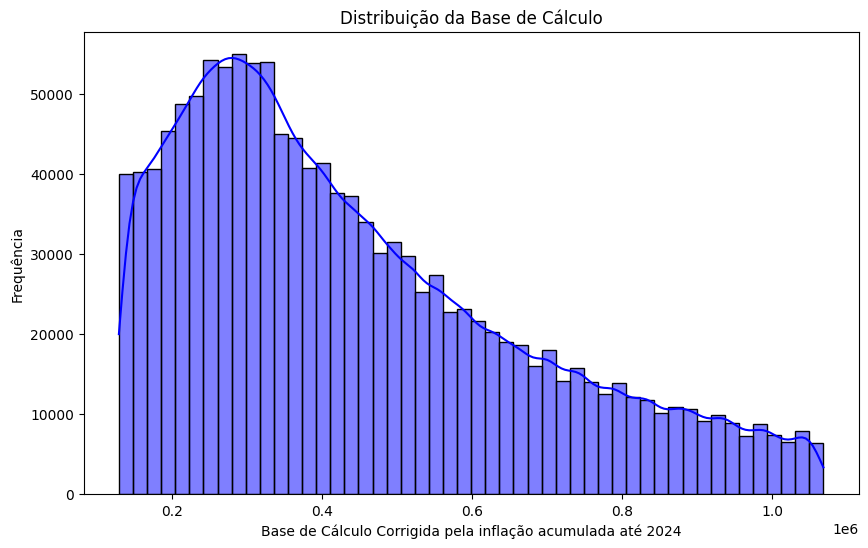

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['base_calculo_corrigida_2024'], bins=50, kde=True, color='blue')

plt.title('Distribuição da Base de Cálculo')
plt.xlabel('Base de Cálculo Corrigida pela inflação acumulada até 2024')
plt.ylabel('Frequência')
plt.show()

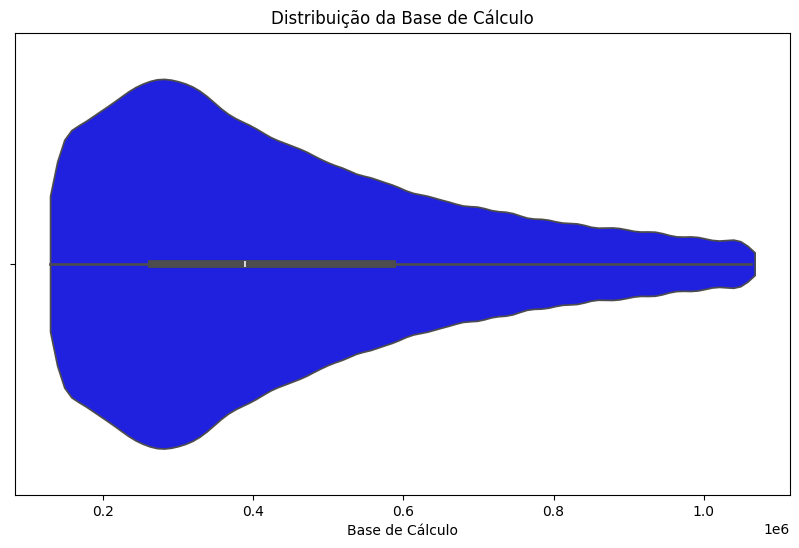

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x=df['base_calculo_corrigida_2024'], cut=0, color='blue')

plt.title('Distribuição da Base de Cálculo')
plt.xlabel('Base de Cálculo')
plt.show()

In [ ]:
curtose = kurtosis(df['base_calculo_corrigida_2024'], fisher=True)  # Fisher=True retorna a curtose padronizada
print(f'Curtose: {curtose}')

Curtose: -0.19291536074927018


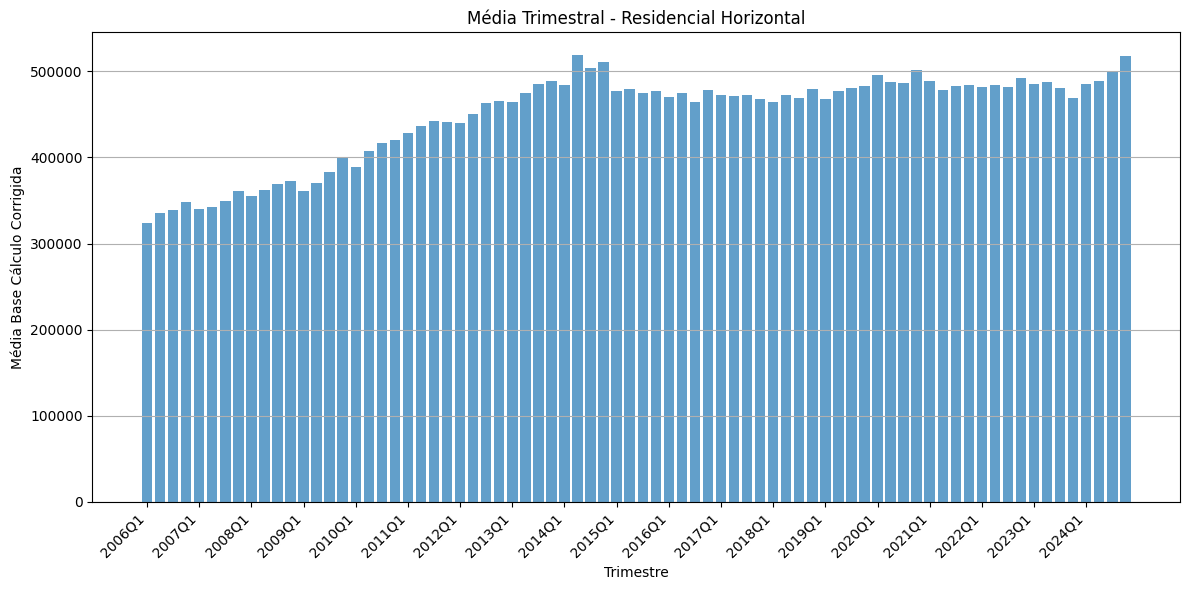

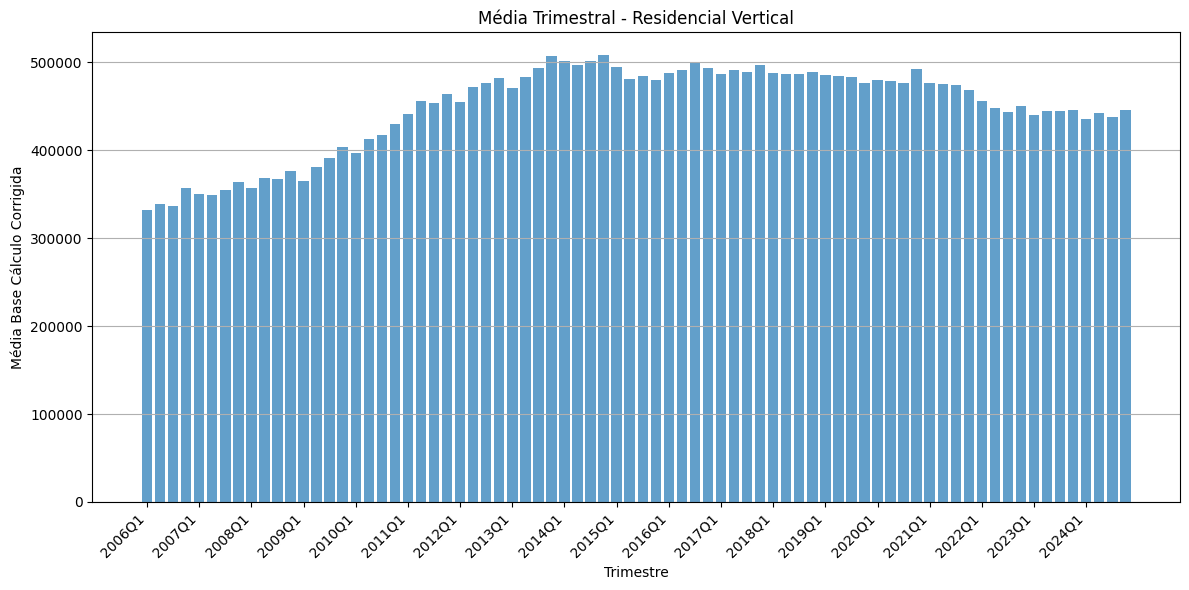

In [ ]:
def analisar_transacoes(df):
    df['MES_ANO'] = df['MES_ANO'].str.strip().str.upper()
    df['descricao_padrao_iptu'] = df['descricao_padrao_iptu'].str.strip().str.upper()

    meses_dict = {
        'JAN': 1, 'FEV': 2, 'MAR': 3, 'ABR': 4, 'MAI': 5, 'JUN': 6,
        'JUL': 7, 'AGO': 8, 'SET': 9, 'OUT': 10, 'NOV': 11, 'DEZ': 12
    }

    df[['Ano', 'Mes']] = df['MES_ANO'].str.split('-', expand=True)
    df = df.dropna(subset=['Mes', 'Ano'])
    df['Mes_Num'] = df['Mes'].map(meses_dict)
    df['Trimestre'] = df['Ano'] + 'Q' + (((df['Mes_Num'] - 1) // 3) + 1).astype(str)

    for categoria in ['RESIDENCIAL HORIZONTAL', 'RESIDENCIAL VERTICAL']:
        df_cat = df[df['descricao_padrao_iptu'] == categoria]
        if df_cat.empty:
            print(f"Nenhum dado encontrado para: {categoria}")
            continue

        df_trimestral = df_cat.groupby('Trimestre')['base_calculo_corrigida_2024'].mean().fillna(0)

        plt.figure(figsize=(12, 6))
        x = range(len(df_trimestral))
        plt.bar(x, df_trimestral.values, alpha=0.7)

        total = len(df_trimestral)
        intervalo = 1 if total <= 20 else 2 if total <= 40 else 4
        mostrar_indices = [i for i in x if i % intervalo == 0]
        mostrar_labels = [df_trimestral.index[i] for i in mostrar_indices]

        plt.xticks(mostrar_indices, mostrar_labels, rotation=45, ha='right')
        plt.title(f'Média Trimestral - {categoria.title()}')
        plt.xlabel('Trimestre')
        plt.ylabel('Média Base Cálculo Corrigida')
        plt.tight_layout()
        plt.grid(axis='y')
        plt.savefig(f"grafico_trimestral_{categoria.lower().replace(' ', '_')}.png")
        plt.show()

try:
    analisar_transacoes(df)
except Exception as e:
    print(f"Erro: {e}")


In [ ]:
def analisar_valor_financiado(df):
    col = 'valor_financiado'

    df_filtrado = df[
        df['tipo_financiamento'].notna() &
        (df['tipo_financiamento'].astype(str).str.strip() != '') &
        (df[col] > 0.01)
    ]

    total_registros = len(df)
    total_validos = len(df_filtrado)
    total_excluidos = total_registros - total_validos
    percentual_excluidos = (total_excluidos / total_registros) * 100

    valores_validos = df_filtrado[col]

    print(f"🔢 Total de registros: {total_registros:,}")
    print(f"❌ Registros excluídos (sem tipo_financiamento ou valor >= 0): {total_excluidos:,} ({percentual_excluidos:.2f}%)")
    print(f"✅ Registros considerados na análise: {total_validos:,}")

    if not valores_validos.empty:
        print(f"\n📊 Estatísticas dos valores considerados:")
        print(f"  Média: R$ {valores_validos.mean():,.2f}")
        print(f"  Mediana: R$ {valores_validos.median():,.2f}")
        print(f"  Máximo: R$ {valores_validos.max():,.2f}")
        print(f"  Mínimo: R$ {valores_validos.min():,.2f}")
        print(f"  Desvio padrão: R$ {valores_validos.std():,.2f}")
        print(f"  Quartil 1 (Q1): R$ {valores_validos.quantile(0.25):,.2f}")
        print(f"  Quartil 3 (Q3): R$ {valores_validos.quantile(0.75):,.2f}")
        print(f"  Valores únicos: {valores_validos.nunique()}")

        print(f"\n🔝 Top 5 maiores valores:")
        print(valores_validos.sort_values(ascending=False).head())

        print(f"\n🔻 Top 5 menores valores (positivos):")
        print(valores_validos.sort_values().head())
    else:
        print("⚠️ Nenhum valor válido encontrado após filtragem.")

try:
    analisar_valor_financiado(df)
except Exception as e:
    print(f"Erro: {e}")


🔢 Total de registros: 1,318,145
❌ Registros excluídos (sem tipo_financiamento ou valor >= 0): 1,000,008 (75.86%)
✅ Registros considerados na análise: 318,137

📊 Estatísticas dos valores considerados:
  Média: R$ 235,688.49
  Mediana: R$ 208,000.00
  Máximo: R$ 1,055,000.00
  Mínimo: R$ 1.00
  Desvio padrão: R$ 123,956.49
  Quartil 1 (Q1): R$ 150,000.00
  Quartil 3 (Q3): R$ 292,500.00
  Valores únicos: 89106

🔝 Top 5 maiores valores:
1263325     1055000.0
1272356     1050000.0
1312981    1024276.12
1317583     1000000.0
1161425     1000000.0
Name: valor_financiado, dtype: Float64

🔻 Top 5 menores valores (positivos):
423686      1.0
671285      1.0
1006383    2.04
1187805    60.0
1161785    70.0
Name: valor_financiado, dtype: Float64
